#  Forecasting the number of antidiabetic drug prescriptions in Australia



- Developing a **forecasting model** to predict the number of antidiabetic drug prescriptions in Australia  
- Applying the modeling procedure with a **SARIMA model**  
- Evaluating our model against a **baseline**  
- Determining the **champion model**



The objective of the project  is **forecasting the number of antidiabetic drug prescriptions in Australia**, from 1991 to 2008. In a professional setting, solving this problem would allow us to **gauge the production of antidiabetic drugs**, such as producing enough to meet the demand while avoiding overproduction.  

The data was recorded by the **Australian Health Insurance Commission**.


In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from itertools import product
from typing import Union
from tqdm import tqdm_notebook

from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox



import warnings
warnings.filterwarnings("ignore")

In [33]:
df = pd.read_csv("AusAntidiabeticDrug.csv")
df.head()

,ds,y
0,1991-07-01,3.526591
1,1991-08-01,3.180891
2,1991-09-01,3.252221
3,1991-10-01,3.611003
4,1991-11-01,3.565869


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ds      204 non-null    object 
 1   y       204 non-null    float64
dtypes: float64(1), object(1)
memory usage: 3.3+ KB


In [35]:
df.tail()

,ds,y
199,2008-02-01,21.654285
200,2008-03-01,18.264945
201,2008-04-01,23.107677
202,2008-05-01,22.912510
203,2008-06-01,19.431740


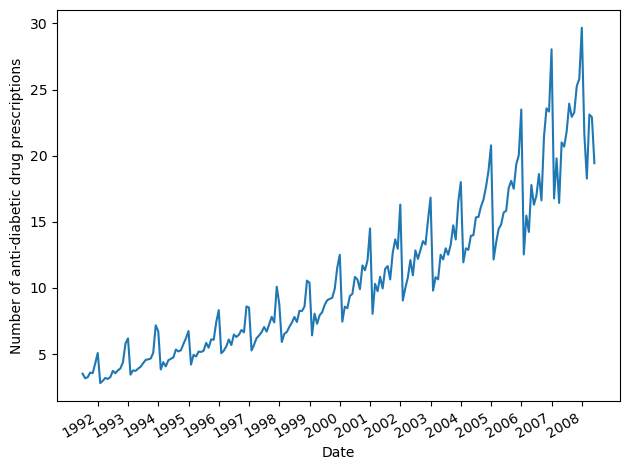

In [55]:

fig, ax = plt.subplots()

ax.plot(df.y)
ax.set_xlabel('Date')
ax.set_ylabel('Number of anti-diabetic drug prescriptions')

plt.xticks(np.arange(6, 203, 12), np.arange(1992, 2009, 1))

fig.autofmt_xdate()
plt.tight_layout()


There is  a clear **trend** in the time series, as the number of prescriptions increases over time. There is also a strong **seasonality**, as each year starts at a low value and ends at a high value. 

To solve this problem:

1. The objective is to **forecast 12 months** of antidiabetic drug prescriptions. Use the **last 36 months** of the dataset as a **test set** to allow for rolling forecasts.

2. **Visualize the time series.**

3. Use **time series decomposition** to extract the **trend** and **seasonal** components.

4. Based on exploration, **determine the most suitable model.**

5. Model the series with the usual steps:

   - Apply **transformations** to make it stationary  
   - Set the values of **d** and **D**, and set the value of **m**  
   - Find the optimal **(p, d, q)(P, D, Q)\_m** parameters  
   - Perform **residual analysis** to validate the chosen model  
   - Perform **rolling forecasts** of 12 months on the test set  

6. **Visualize the forecasts.**

7. Compare the model’s performance to a **baseline**. 

8. Conclude whether the model **should be used** or not.




In [35]:
df.tail()

,ds,y
199,2008-02-01,21.654285
200,2008-03-01,18.264945
201,2008-04-01,23.107677
202,2008-05-01,22.912510
203,2008-06-01,19.431740


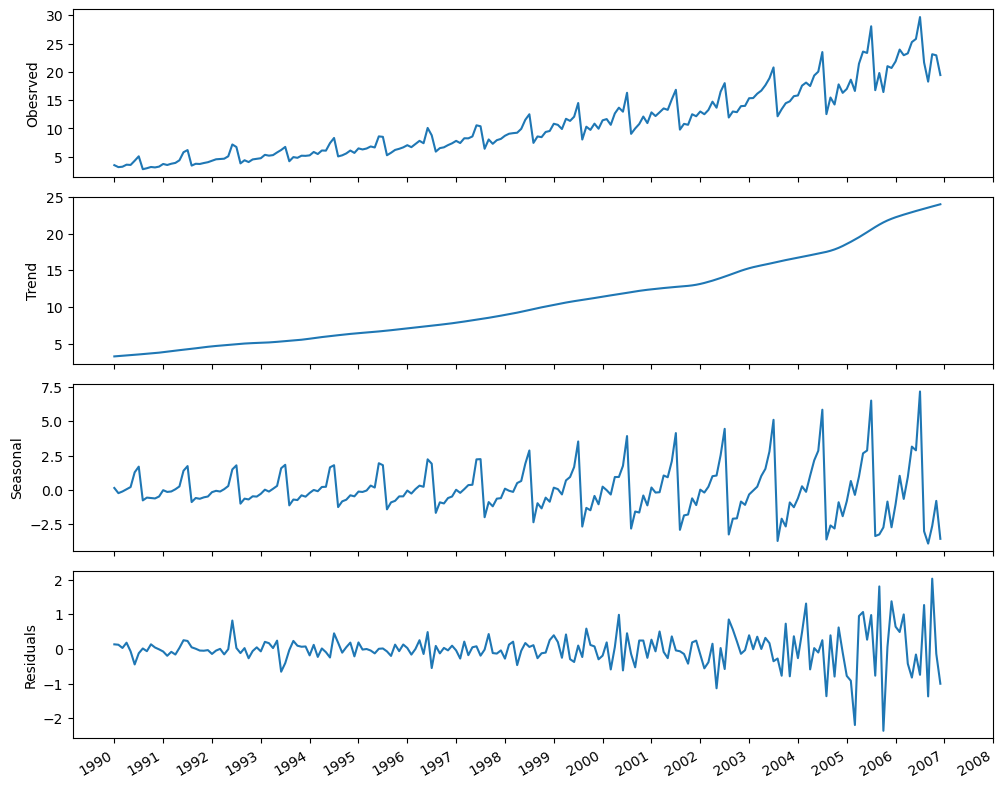

In [36]:
decomposition = STL(df['y'], period=12).fit()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(10,8))

ax1.plot(decomposition.observed)
ax1.set_ylabel("Obesrved")

ax2.plot(decomposition.trend)
ax2.set_ylabel("Trend")

ax3.plot(decomposition.seasonal)
ax3.set_ylabel("Seasonal")

ax4.plot(decomposition.resid)
ax4.set_ylabel("Residuals")

plt.xticks(np.arange(0, 220, 12), np.arange(1990, 2009, 1))

fig.autofmt_xdate()
plt.tight_layout()

In [37]:
ad_fuller_result = adfuller(df['y'])

print(f'ADF Statistic: {ad_fuller_result[0]} \np-value: {ad_fuller_result[1]}')


ADF Statistic: 3.1451856893067403 
p-value: 1.0


We can not reject the null hypothesis that the time series is not stationary.  
Thus, a first-order differencing will be applied.

In [38]:
df_diff = np.diff(df['y'], n=1)

ad_fuller_result = adfuller(df_diff)

print(f'ADF Statistic: {ad_fuller_result[0]} \np-value: {ad_fuller_result[1]}')


ADF Statistic: -2.495172147449708 
p-value: 0.11665341686469549


Again the p-values is 0.11 which is greater than 0.05, thus we can not reject the null hypothesis.  
Seasonal differencing and test for stationarity once again will be applied

In [39]:
df_diff_seasonal = np.diff(df_diff, n=12)

ad_fuller_result = adfuller(df_diff_seasonal)
 
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -19.84844009816495
p-value: 0.0


The p-value now is 0 indicating that the time series is stationary and we can reject the null hypothesis.

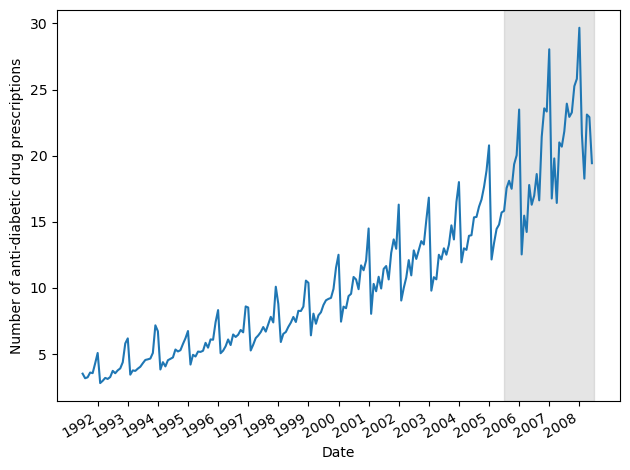

In [43]:
fig, ax = plt.subplots()

ax.plot(df.y)
ax.set_xlabel("Date")
ax.set_ylabel('Number of anti-diabetic drug prescriptions')
ax.axvspan(168, 204, color='#808080', alpha=0.2)

plt.xticks(np.arange(6, 203, 12), np.arange(1992, 2009, 1))

fig.autofmt_xdate()
plt.tight_layout()

In [40]:
def optimize_SARIMA(endog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(
                endog, 
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

Next we need to define the range of possible values for p, q, P and Q and to select the model with the lowest AIC

In [41]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)
Ps = range(0, 4, 1)
Qs = range(0, 4, 1)

SARIMA_order_list = list(product(ps, qs, Ps, Qs))

train = df['y'][:-36]
test = df['y'][-36:]

d = 1
D = 1
s = 12

SARIMA_result_df = optimize_SARIMA(train, SARIMA_order_list, d, D, s)
SARIMA_result_df

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(3, 1, 1, 3)",270.951096
1,"(3, 3, 1, 3)",271.437262
2,"(3, 2, 1, 3)",272.222636
3,"(3, 3, 0, 1)",272.580413
4,"(3, 3, 2, 0)",272.949441
...,...,...
251,"(0, 0, 3, 1)",351.425175
252,"(0, 0, 1, 1)",351.466837
253,"(0, 0, 0, 1)",354.751719
254,"(0, 0, 1, 0)",357.173706


SARIMA(3,1,1)(1,1,3)_12 model has the lowest AIC which is 270.95

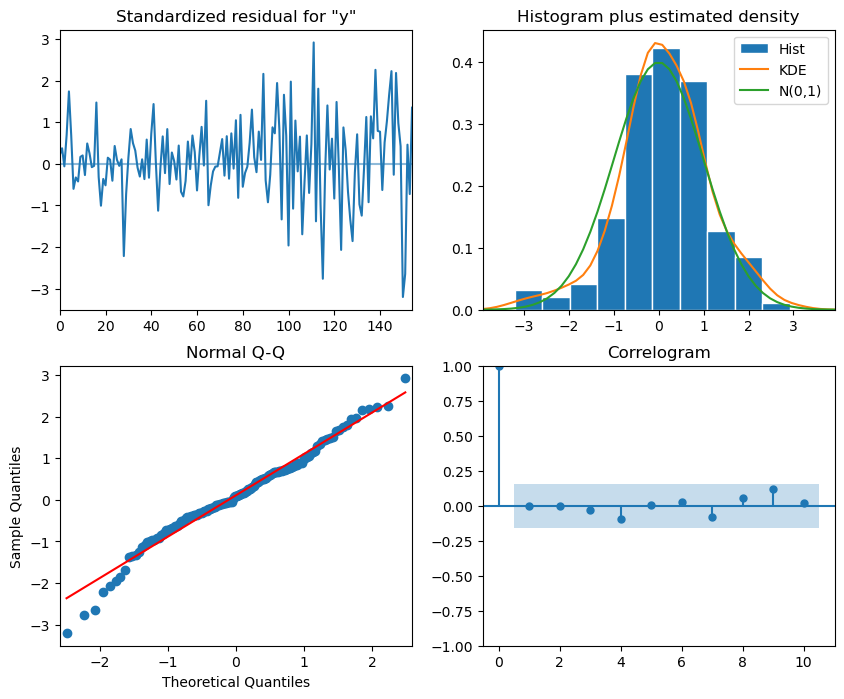

In [44]:
SARIMA_model = SARIMAX(train, order=(3,1,1), seasonal_order=(1,1,3,12), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False)
SARIMA_model_fit.plot_diagnostics(figsize=(10,8));

The results show that our residuals are completely random, which is exactly what we are looking for in a good model.

The final test to determine whether we can use this model for forecasting or not is the Ljung-Box test.

In [47]:

residuals = SARIMA_model_fit.resid

results = acorr_ljungbox(residuals, np.arange(1,11,1))
results

,lb_stat,lb_pvalue
1,0.436900,0.508622
2,0.627627,0.730655
3,0.646138,0.885793
4,2.258433,0.688347
5,2.950538,0.707611
6,3.389492,0.758609
7,9.982148,0.189587
8,10.592123,0.225898
9,11.854149,0.221657
10,11.985468,0.286030


The returned p-values are all greater than 0.05. Therefore, we do not reject the null hypothesis, and we conclude that the residuals are independent and uncorrelated, just like white noise.

Our model has passed all the tests from the residuals analysis, and we are ready to use it for forecasting.

In [48]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    end_idx = train_len

    if method == 'last_season':
        pred_last_season = []
        
        for i in range(train_len, total_len, window):
            last_season = df['y'][i-window:i].values
            pred_last_season.extend(last_season)
            
        return pred_last_season
    
    elif method == 'SARIMA':
        pred_SARIMA = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df['y'][:i], order=(2,1,3), seasonal_order=(1,1,3,12), simple_differencing=False)
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_SARIMA.extend(oos_pred)
            
        return pred_SARIMA

In [49]:
pred_df = df[168:]

TRAIN_LEN = 168
HORIZON = 36
WINDOW = 12

pred_df['last_season'] = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'last_season')

pred_df

,ds,y,last_season
168,2005-07-01,15.829550,15.339097
169,2005-08-01,17.554701,15.370764
170,2005-09-01,18.100864,16.142005
171,2005-10-01,17.496668,16.685754
172,2005-11-01,19.347265,17.636728
173,2005-12-01,20.031291,18.869325
174,2006-01-01,23.486694,20.778723
175,2006-02-01,12.536987,12.154552
176,2006-03-01,15.467018,13.402392
177,2006-04-01,14.233539,14.459239


In [50]:
pred_df['SARIMA'] = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'SARIMA')

pred_df

,ds,y,last_season,SARIMA
168,2005-07-01,15.829550,15.339097,16.749641
169,2005-08-01,17.554701,15.370764,16.686262
170,2005-09-01,18.100864,16.142005,17.189064
171,2005-10-01,17.496668,16.685754,18.089358
172,2005-11-01,19.347265,17.636728,18.659547
173,2005-12-01,20.031291,18.869325,19.949134
174,2006-01-01,23.486694,20.778723,22.076531
175,2006-02-01,12.536987,12.154552,13.744773
176,2006-03-01,15.467018,13.402392,15.084795
177,2006-04-01,14.233539,14.459239,15.657806


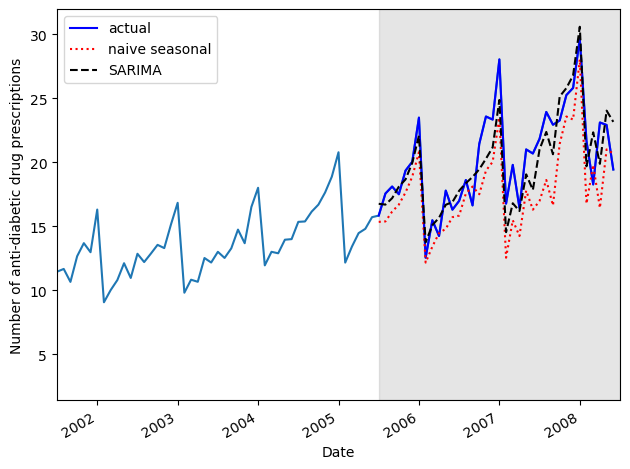

In [51]:
fig, ax = plt.subplots()

ax.plot(df.y)
ax.plot(pred_df.y, 'b-', label='actual')
ax.plot(pred_df.last_season, 'r:', label='naive seasonal')
ax.plot(pred_df.SARIMA, 'k--', label='SARIMA')
ax.set_xlabel('Date')
ax.set_ylabel('Number of anti-diabetic drug prescriptions')
ax.axvspan(168, 204, color='#808080', alpha=0.2)

ax.legend(loc=2)

plt.xticks(np.arange(6, 203, 12), np.arange(1992, 2009, 1))
plt.xlim(120, 204)

fig.autofmt_xdate()
plt.tight_layout()

## Evaluate

In [52]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [53]:
mape_naive_seasonal = mape(pred_df.y, pred_df.last_season)
mape_SARIMA = mape(pred_df.y, pred_df.SARIMA)

print(mape_naive_seasonal, mape_SARIMA)

12.686561923100614 7.89744509663923


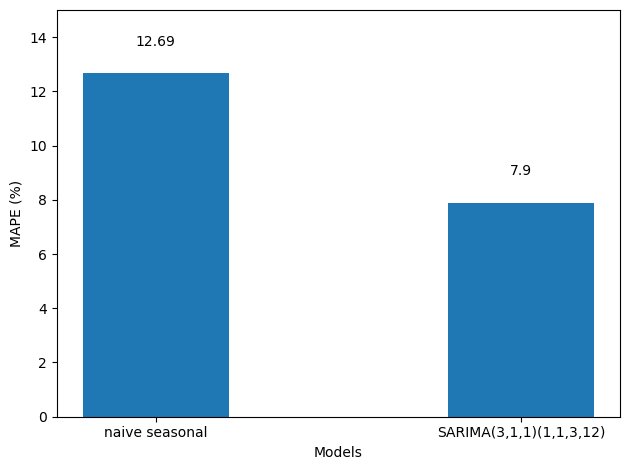

In [56]:
fig, ax = plt.subplots()

x = ['naive seasonal', 'SARIMA(3,1,1)(1,1,3,12)']
y = [mape_naive_seasonal, mape_SARIMA]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 15)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 1, s=str(round(value,2)), ha='center')

plt.tight_layout()

Since the SARIMA model achieves the lowest MAPE, we can conclude that the SARIMA(3,1,1)(1,1,3)12 model should be used to forecast the monthly number of antidiabetic drug prescriptions in Australia.